# Decipher modifications 






## Structure of the variational family


Variational family factorizes into 
$\begin{eqnarray*}
q_{\mathtt{joint}} := q(v_s, v_x, z_x, z_y, z_s) & = & \prod_{i=1}^N q(v_{s,i}, v_{x,i}, z_{x,i}, z_{y,i}, z_{s,i}) \\
q(v_{s,i}, v_{x,i}, z_{x,i}, z_{y,i}, z_{s,i}) & = & q(v_{x,i}|z_{x,i},z_{s,i}) \times q(z_{x,i},z_{s,i}|x_i) \times q(v_{s,i}|z_{s,i},  z_{y,i}) \times q(z_{s,i}|y_i) \times q(z_{y,i}|y_i)
\end{eqnarray*}$ 


Set
- $q(v_{x,i}|z_{x,i},z_{s,i}) = \mathcal{N}(d^{\rightarrow v_x}_{\mathtt{mean}}(z_{x,i}, z_{s,i}), d^{\rightarrow v_x}_{\mathtt{var}}(z_{x,i}, z_{s,i}))$
- $q(v_{s,i}|z_{y,i},z_{s,i}) = \mathcal{N}(d^{\rightarrow v_s}_{\mathtt{mean}}(z_{y,i}, z_{s,i}), d^{\rightarrow v_s}_{\mathtt{var}}(z_{y,i}, z_{s,i}))$
- $q(z_{x,i},z_{s,i}|x_i) = \mathcal{N}(d^{\rightarrow z_{s,x}}_{\mathtt{mean}}(x_i), d^{\rightarrow z_{s,x}}_{\mathtt{var}}(x_i))$
- $q(z_{s,i}|y_i) = \mathcal{N}(d^{\rightarrow z_{s,y}}_{\mathtt{mean}}(y_i), d^{\rightarrow z_{s,y}}_{\mathtt{var}}(y_i))$
- $q(z_{y,i}|y_i) = \mathcal{N}(d^{\rightarrow z_{y}}_{\mathtt{mean}}(y_i), d^{\rightarrow z_{y}}_{\mathtt{var}}(y_i))$

Variational inference objective:

$\begin{eqnarray} 
& \mathcal{L}_{\text{ELBO}}(q)  = \sum_{i=1}^{N} \mathbb{E}_{q_{\mathtt{joint}} }\bigg( \sum_g \log p(x_{i,g}|z_{s,i}, z_{x,i}, \theta_g) + \log \frac{p(z_{s,i}, z_{x,i}|v_{x,i}, v_{s,i})}{q(z_{x,i}, z_{s,i}|x_{i,g})} + \beta_x \log \frac{p(v_{x,i})}{q(v_{x,i}|z_{x,i},z_{s,i})}  \\
& + \sum_t  \log p(y_{i,t}|z_{s,i}, z_{y,i}, \eta_t) + \log \frac{p(z_{s,i}, z_{y,i}|v_{s,i})}{q(z_{y,i}, z_{s,i}|y_{i,t})} + \beta_s \log \frac{p(v_{s,i})}{q(v_{s,i}|z_{y,i},z_{s,i})} \bigg)
\end{eqnarray}$

$v \in \mathbb{R}^2, z \in \mathbb{R}^{10}, x, y \in \mathbb{R}^{2000}$

### Decipher module adapted for ATAC

In [2]:
conda install pytorch torchvision -c pytorch

Retrieving notices: ...working... done
Channels:
 - pytorch
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/clairehe/anaconda3/envs/claire

  added / updated specs:
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2023.11.17         |  py310hca03da5_0         159 KB
    pytorch-2.1.2              |         py3.10_0        50.7 MB  pytorch
    torchvision-0.16.2         |        py310_cpu         6.5 MB  pytorch
    ------------------------------------------------------------
                                           Total:        57.3 MB

The following NEW packages will be INSTALLED:

  ffmpeg             pkgs/main/osx-arm64::ffmpeg-4.2.2-h04105a8_0 
  gnutls             pkgs/main/osx-arm64::gnutls-3.6.15-h887c41c_0 
  lame               pkgs/main/osx-arm64::lame-3.100-h

In [6]:
!pip3 install pyro-ppl 

  Using cached pyro_ppl-1.8.6-py3-none-any.whl.metadata (7.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached pyro_api-0.1.2-py3-none-any.whl (11 kB)
Using cached pyro_ppl-1.8.6-py3-none-any.whl (732 kB)


In [7]:
import dataclasses
from dataclasses import dataclass
from typing import Sequence, Union

import numpy as np
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import torch.nn as nn
import torch.utils.data
from torch.distributions import constraints
from torch.nn.functional import softmax, softplus


In [9]:
pip install randomname

  Using cached randomname-0.2.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached fire-0.5.0.tar.gz (88 kB)
  Preparing metadata (setup.py) ... done
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Created wheel for randomname: filename=randomname-0.2.1-py3-none-any.whl size=89194 sha256=03cf733a2658fb67a126a534d3690a53cebb6b0b639b39fa5bdb69df4af19489
  Stored in directory: /Users/clairehe/Library/Caches/pip/wheels/10/50/8a/25f3820d26a431ffed1834d72ff2eb349123cf2b44c5a45727
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=a02e229e7d5f1e78b87a2b9068dc4936d30b0ecb087d39a514599407e724a3ca
  Stored in directory: /Users/clairehe/Library/Caches/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built randomname fire
Note: you may need to restart the kernel to use updated packages.


In [12]:
conda install -c conda-forge scanpy python-igraph leidenalg

Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/clairehe/anaconda3/envs/claire

  added / updated specs:
    - leidenalg
    - python-igraph
    - scanpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anndata-0.10.3             |     pyhd8ed1ab_0          94 KB  conda-forge
    cached-property-1.5.2      |       hd8ed1ab_1           4 KB  conda-forge
    cached_property-1.5.2      |     pyha770c72_1          11 KB  conda-forge
    h5py-3.6.0                 |nompi_py310hb8bbf05_100         1.3 MB  conda-forge
    leidenalg-0.9.1            |  py310h0f1eb42_0         121 KB  conda-forge
    metis-5.1.1                |       h965bd2d_2         3.7 MB  conda-forge
    patsy-0.5.4                |     pyhd8ed1ab_0         183 KB  conda-forge
    python-igraph-0.10.4       |  py310he372fcf_0 

In [13]:
import os
os.chdir('/Users/clairehe/Documents/GitHub/decipher_with_ATAC/decipher-ATAC/')

import decipher
import scanpy as sc

# Testing on PDAC data

In [14]:
import scipy as sp
from decipher.tools._decipher import Decipher_with_ATAC, DecipherConfig_withATAC
from decipher.tools.decipher import decipherATAC_train

In [15]:
pdac_atac = sc.read_h5ad("/Users/clairehe/Documents/GitHub/decipher_with_ATAC/data/pdac_atac.h5ad")
pdac_atac.X = sp.sparse.csr_matrix(pdac_atac.X)

In [16]:
pdac_rna = sc.read_h5ad("/Users/clairehe/Documents/GitHub/decipher_with_ATAC/data/pdac_rna.h5ad")
pdac_rna.X = sp.sparse.csr_matrix(pdac_rna.X)

In [16]:
pdac_rna

AnnData object with n_obs × n_vars = 3988 × 21821
    obs: 'orig.ident', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'pct_reads_in_peaks', 'blacklist_ratio', 'ATAC_snn_res.1.2', 'seurat_clusters', 'predicted.id', 'prediction.score.B.cell', 'prediction.score.Endothelial', 'prediction.score.Ductal', 'prediction.score.T.cell', 'prediction.score.Epi.Immune', 'prediction.score.Proliferating', 'prediction.score.Tumor.1', 'prediction.score.Macrophage', 'prediction.score.Acinar', 'prediction.score.Fibr

In [17]:
pdac_atac

AnnData object with n_obs × n_vars = 3988 × 258561
    obs: 'orig.ident', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'pct_reads_in_peaks', 'blacklist_ratio', 'ATAC_snn_res.1.2', 'seurat_clusters', 'predicted.id', 'prediction.score.B.cell', 'prediction.score.Endothelial', 'prediction.score.Ductal', 'prediction.score.T.cell', 'prediction.score.Epi.Immune', 'prediction.score.Proliferating', 'prediction.score.Tumor.1', 'prediction.score.Macrophage', 'prediction.score.Acinar', 'prediction.score.Fib

In [17]:
decipherATAC_train(
    pdac_rna,
    pdac_atac,
    decipher_config=DecipherConfig_withATAC(n_epochs=50, beta=0.5),
    plot_every_k_epoch=-1,
    plot_kwargs=dict(
        color=[
         "predicted.id"
        ])
)


2023-12-16 15:18:09,367 | INFO : Added `.obs['decipher_split']`: the Decipher train/validation split.
 398 cells in validation set.
2023-12-16 15:18:09,375 | INFO : Added `.obs['decipher_split']`: the Decipher train/validation split.
 398 cells in validation set.


V5


Epoch 0 | train elbo: 67553.77 | val ll: 18324.09:   0%|          | 0/50 [01:31<?, ?it/s]2023-12-16 15:36:16,899 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-16 15:36:16,901 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
2023-12-16 15:36:16,907 | INFO : Saving decipher model with run_id 2023-12-16-15-36-16-offline-red-natural.
2023-12-16 15:36:17,596 | INFO : Saving decipher model with run_id 2023-12-16-15-36-17-connected-charcoal-volumetric.
Epoch 1 | train elbo: 61850.20 | val ll: 17964.14:   2%|▏         | 1/50 [4:48:57<14:48:07, 1087.49s/it]2023-12-16 20:38:05,921 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-16 20:38:05,925 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
2023-12-16 20:38:05,926 | INFO : Saving decipher model with run_id 2023-12-16-20-38-05-relative-brass-paste.
2023-12-16 20:38:06,580 | INFO : Saving decipher model with run_id 2023-12-16-20-38-06-organic-weary-chimichanga.
Epoch 2 | train elbo: 

ValueError: Expected parameter loc (Tensor of shape (64, 20)) of distribution Normal(loc: torch.Size([64, 20]), scale: torch.Size([64, 20])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<SliceBackward0>)
                                    Trace Shapes:              
                                     Param Sites:              
      decipher$$$decoder_vx_to_zx.layers.0.weight     64      2
        decipher$$$decoder_vx_to_zx.layers.0.bias            64
      decipher$$$decoder_vx_to_zx.layers.1.weight     20     64
        decipher$$$decoder_vx_to_zx.layers.1.bias            20
 decipher$$$decoder_vx_to_zx.batch_norms.0.weight            64
   decipher$$$decoder_vx_to_zx.batch_norms.0.bias            64
      decipher$$$decoder_vy_to_zy.layers.0.weight     64      2
        decipher$$$decoder_vy_to_zy.layers.0.bias            64
      decipher$$$decoder_vy_to_zy.layers.1.weight     20     64
        decipher$$$decoder_vy_to_zy.layers.1.bias            20
 decipher$$$decoder_vy_to_zy.batch_norms.0.weight            64
   decipher$$$decoder_vy_to_zy.batch_norms.0.bias            64
      decipher$$$decoder_vs_to_zs.layers.0.weight     64      2
        decipher$$$decoder_vs_to_zs.layers.0.bias            64
      decipher$$$decoder_vs_to_zs.layers.1.weight     20     64
        decipher$$$decoder_vs_to_zs.layers.1.bias            20
 decipher$$$decoder_vs_to_zs.batch_norms.0.weight            64
   decipher$$$decoder_vs_to_zs.batch_norms.0.bias            64
     decipher$$$decoder_zxzs_to_x.layers.0.weight  21821     20
       decipher$$$decoder_zxzs_to_x.layers.0.bias         21821
       decipher$$$decoder_zy_to_y.layers.0.weight 258561     10
         decipher$$$decoder_zy_to_y.layers.0.bias        258561
     decipher$$$encoder_x_to_zxzs.layers.0.weight    128  21821
       decipher$$$encoder_x_to_zxzs.layers.0.bias           128
     decipher$$$encoder_x_to_zxzs.layers.1.weight     40    128
       decipher$$$encoder_x_to_zxzs.layers.1.bias            40
decipher$$$encoder_x_to_zxzs.batch_norms.0.weight           128
  decipher$$$encoder_x_to_zxzs.batch_norms.0.bias           128
       decipher$$$encoder_y_to_zy.layers.0.weight    128 258561
         decipher$$$encoder_y_to_zy.layers.0.bias           128
       decipher$$$encoder_y_to_zy.layers.1.weight     20    128
         decipher$$$encoder_y_to_zy.layers.1.bias            20
  decipher$$$encoder_y_to_zy.batch_norms.0.weight           128
    decipher$$$encoder_y_to_zy.batch_norms.0.bias           128
       decipher$$$encoder_zx_to_v.layers.0.weight    128  21831
         decipher$$$encoder_zx_to_v.layers.0.bias           128
       decipher$$$encoder_zx_to_v.layers.1.weight      4    128
         decipher$$$encoder_zx_to_v.layers.1.bias             4
  decipher$$$encoder_zx_to_v.batch_norms.0.weight           128
    decipher$$$encoder_zx_to_v.batch_norms.0.bias           128
      decipher$$$encoder_zsy_to_v.layers.0.weight    128 258581
        decipher$$$encoder_zsy_to_v.layers.0.bias           128
      decipher$$$encoder_zsy_to_v.layers.1.weight      4    128
        decipher$$$encoder_zsy_to_v.layers.1.bias             4
 decipher$$$encoder_zsy_to_v.batch_norms.0.weight           128
   decipher$$$encoder_zsy_to_v.batch_norms.0.bias           128
                                    Sample Sites:              
                                       batch dist             |
                                            value     64      |

In [ ]:
pdac_atac.obsm['decipher_vs']

In [ ]:
pdac_atac.obsm['vs_var']

In [ ]:
X_plot = pdac_atac.obsm['decipher_vs'][:,0]
Y_plot = pdac_atac.obsm['decipher_vs'][:,1]
Z_plot = pdac_atac.obsm['vs_var']

In [72]:
decipher.config

DecipherConfig_withATAC(dim_z=10, dim_v=2, layers_v_to_z=(64,), layers_z_to_x=(), layers_z_to_y=(), beta=0.1, seed=0, learning_rate=0.005, val_frac=0.1, batch_size=64, n_epochs=2, dim_genes=21821, dim_atac=258561, n_cells=3590, prior='normal', _initialized_from_adata=True)

In [78]:
pdac_atac

AnnData object with n_obs × n_vars = 3988 × 258561
    obs: 'orig.ident', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'pct_reads_in_peaks', 'blacklist_ratio', 'ATAC_snn_res.1.2', 'seurat_clusters', 'predicted.id', 'prediction.score.B.cell', 'prediction.score.Endothelial', 'prediction.score.Ductal', 'prediction.score.T.cell', 'prediction.score.Epi.Immune', 'prediction.score.Proliferating', 'prediction.score.Tumor.1', 'prediction.score.Macrophage', 'prediction.score.Acinar', 'prediction.score.Fib

In [ ]:
import hdf5plugin
pdac_rna.write_h5ad('pdac_rna_decipher.h5ad')
pdac_atac.write_h5ad('pdac_atac_decipher.h5ad')

In [149]:
#plot_decipher_v(pdac_atac, basis="decipher_vs", **dict(color=["predicted.id"]))

array([[ 1.0115982 , -0.3263243 ],
       [ 1.0837866 , -0.61431825],
       [ 1.0924392 , -1.5572293 ],
       ...,
       [-2.9927197 , -0.7304146 ],
       [-3.7208602 , -0.7303487 ],
       [-0.40201595, -0.59209025]], dtype=float32)

/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_38390/976451660.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  predictive_v = np.array([np.random.multivariate_normal(pdac_rna.obsm['decipher_vx'][i,:],vx_sigma[i,:,:]) for i in range(pdac_rna.shape[0])])
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remov

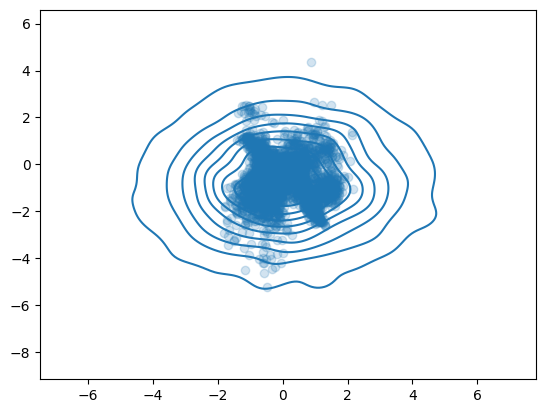

In [140]:
import seaborn as sns

vx_sigma = np.array([np.diag(pdac_rna.obsm['vx_var'][i]) for i in range(pdac_rna.shape[0])])
predictive_v = np.array([np.random.multivariate_normal(pdac_rna.obsm['decipher_vx'][i,:],vx_sigma[i,:,:]) for i in range(pdac_rna.shape[0])])                    
sns.kdeplot(x=predictive_v[:,0], y=predictive_v[:,1]) #, c=np.mean(np.mean(vs_sigma, axis=2),axis=1))
plt.scatter(pdac_rna.obsm['decipher_vx'][:,0],pdac_rna.obsm['decipher_vx'][:,1], alpha=0.2)

plt.show()

/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_38390/2578142756.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  predictive_v = np.array([np.random.multivariate_normal(pdac_atac.obsm['decipher_vs'][i,:],vs_sigma[i,:,:]) for i in range(pdac_atac.shape[0])])
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be re

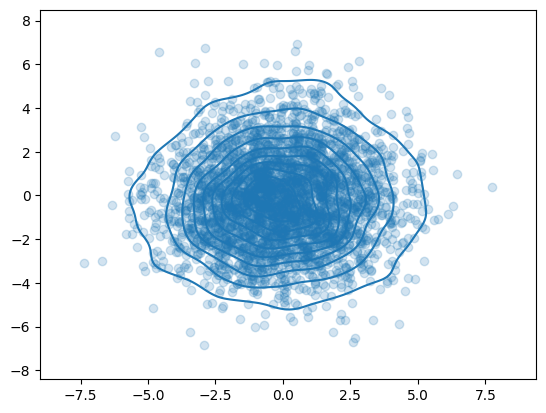

In [141]:
from scipy.stats import multivariate_normal

vs_sigma = np.array([np.diag(pdac_atac.obsm['vs_var'][i]) for i in range(pdac_atac.shape[0])])
predictive_v = np.array([np.random.multivariate_normal(pdac_atac.obsm['decipher_vs'][i,:],vs_sigma[i,:,:]) for i in range(pdac_atac.shape[0])])                    
sns.kdeplot(x=predictive_v[:,0], y=predictive_v[:,1])
plt.scatter(predictive_v[:,0], predictive_v[:,1], alpha=0.2) #, c=np.mean(np.mean(vs_sigma, axis=2),axis=1))
plt.show()

In [196]:
pbmc_atac = sc.read_h5ad("/Users/clairehe/Downloads/PBMC_processed_ATAC.h5ad")
#pbmc_atac.X = sp.sparse.csr_matrix(pbmc_atac.X)

pbmc_atac = sc.read_10x_h5("/Users/clairehe/Downloads/PBMC_RNA.h5")
#pbmc_atac.X = sp.sparse.csr_matrix(pbmc_atac.X)

/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [197]:
pbmc_rna.var.feature_types

MIR1302-2HG    Gene Expression
FAM138A        Gene Expression
OR4F5          Gene Expression
AL627309.1     Gene Expression
AL627309.3     Gene Expression
                    ...       
AC141272.1     Gene Expression
AC023491.2     Gene Expression
AC007325.1     Gene Expression
AC007325.4     Gene Expression
AC007325.2     Gene Expression
Name: feature_types, Length: 36601, dtype: object

In [179]:
pbmc_index=pbmc_atac.obs['decipher_split'].index.to_list()
pbmc_index[0]

'pbmc#ACTTGAATCAGCTAAC-1'

In [183]:
pbmc_index = [pbmc_index[i][5:] for i in range(len(pbmc_index))]

In [190]:
pbmc_index.sort()
pbmc_index[:5]

['AAACAGCCAAATATCC-1',
 'AAACAGCCAGGAACTG-1',
 'AAACAGCCAGGCTTCG-1',
 'AAACCAACACCTGCTC-1',
 'AAACCAACAGATTCAT-1']

In [199]:
pbmc_rna_index = pbmc_rna.obs['decipher_split'].index.to_list()

In [200]:
pbmc_rna_index[:5]

['AAACAGCCAAATATCC-1',
 'AAACAGCCAGGAACTG-1',
 'AAACAGCCAGGCTTCG-1',
 'AAACCAACACCTGCTC-1',
 'AAACCAACAGATTCAT-1']

In [227]:
missing = sorted(list(set(pbmc_rna_index).difference(pbmc_index)))
added = sorted(list(set(pbmc_index).difference(pbmc_rna_index)))

In [228]:
len(missing), len(added)

(85, 83)

In [230]:
[(missing[i], added[i]) for i in range(5)]

[('AAGTGAAGTATGTGGC-1', 'AAAGGCTCAAAGGCCA-1'),
 ('AATGGCGCAAGCCACT-1', 'AACAGCAAGCCGCAAC-1'),
 ('AATTGCCAGTACTGGT-1', 'AACTAGTGTTAAGTGT-1'),
 ('ACATTGCAGGAATAAC-1', 'AAGAACAGTAATCGCA-1'),
 ('ACCATTAAGGAGCAAC-1', 'AAGCGAGGTGTTAAAC-1')]

We should have matching rna and atac. Except for those observations, it seems the data is paired. Keeping shared elements.

In [234]:
keep_index = list(set(pbmc_rna_index) & set(pbmc_index))
print(len(keep_index))

2626


In [238]:
new_rna = pbmc_rna[keep_index]
new_atac = pbmc_atac[keep_index]

/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [109]:
new_rna.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38
AC023491.2,ENSG00000278633,Gene Expression,GRCh38
AC007325.1,ENSG00000276017,Gene Expression,GRCh38
AC007325.4,ENSG00000278817,Gene Expression,GRCh38


In [75]:
config = DecipherConfig_withATAC(
    dim_genes = new_rna.shape[1],
    dim_atac= new_atac.shape[1],
    n_epochs = 10)
model = decipherATAC_train(
    new_rna,
    new_atac,
    decipher_config=DecipherConfig_withATAC(),
    plot_every_k_epoch=-1,
    plot_kwargs=dict()
)


2023-12-06 11:19:52,668 | INFO : Added `.obs['decipher_split']`: the Decipher train/validation split.
 262 cells in validation set.
2023-12-06 11:19:52,678 | INFO : Added `.obs['decipher_split']`: the Decipher train/validation split.
 262 cells in validation set.


V5


Epoch 45 | train elbo: 11868.58 | val ll: 6010.29:  45%|████▌     | 45/100 [45:33<55:40, 60.74s/it]   

Early stopping.


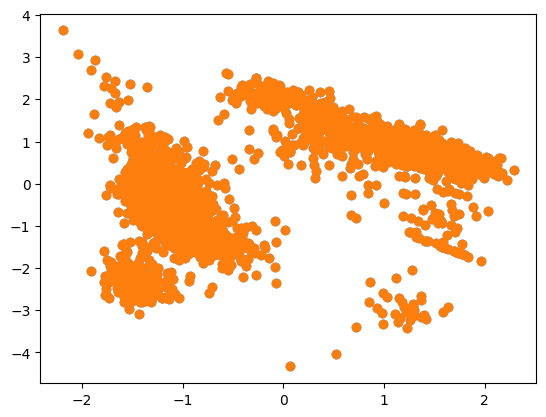

In [248]:
plt.scatter(new_rna.obsm['decipher_vx'][:,0],new_rna.obsm['decipher_vx'][:,1])
plt.show()

In [ ]:
import hdf5plugin
new_rna.write_h5ad('pdac_rna_decipher.h5ad')
new_atac.write_h5ad('pdac_atac_decipher.h5ad')

In [251]:
pip install hdf5plugin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 7.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [50]:
new_rna =  sc.read_h5ad("/Users/clairehe/Documents/GitHub/decipher_with_ATAC/data/pbmc_rna_decipher.h5ad")
new_atac = sc.read_h5ad("/Users/clairehe/Documents/GitHub/decipher_with_ATAC/data/pbmc_atac_decipher.h5ad")

In [51]:
# with cell type
annotated_rna = sc.read_h5ad('/Users/clairehe/Downloads/annotated_pbmc_rna.h5')
#read_10x_h5('/Users/clairehe/Downloads/annotated_pbmc_rna.h5')

In [20]:
annotated_rna

AnnData object with n_obs × n_vars = 2626 × 36601
    obs: 'decipher_split', 'blank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'n_counts', 'pheno_louvain', 'celltypes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltypes_colors', 'neighbors', 'pheno_jaccard_q', 'pheno_louvain_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'decipher_vx', 'decipher_zx', 'vx_var'

In [9]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

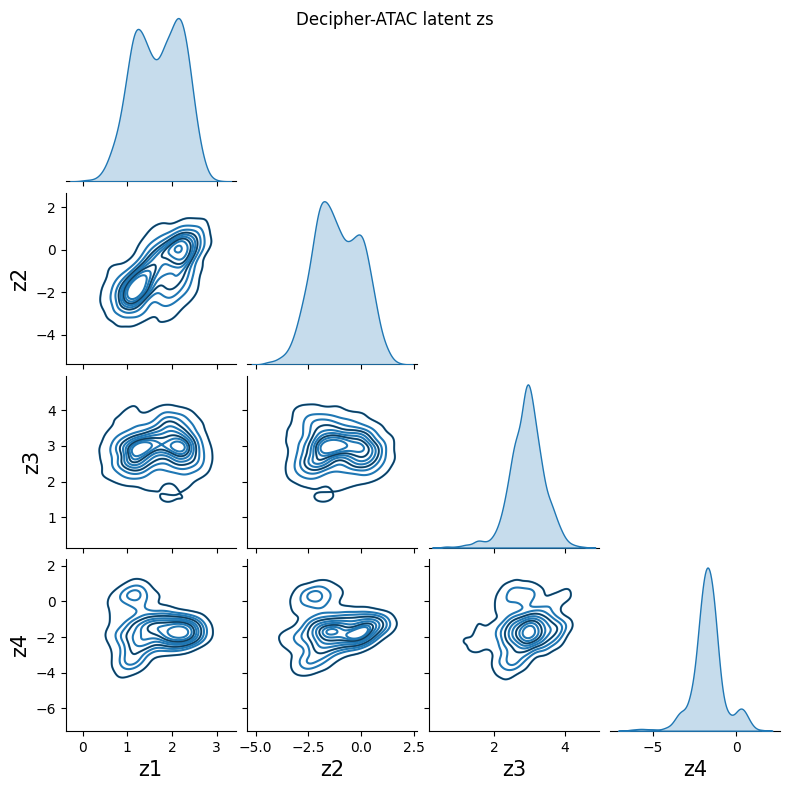

In [52]:
def f(hue,*args, **kwargs):
    sns.kdeplot(**kwargs)

tmp_data = pd.DataFrame(new_atac.obsm['decipher_zs'], columns=["z%d" % (i+1) for i in range(10)])
#tmp_data["origin"] = new_atac.obs["origin"].values
#tmp_data["cell_type_merged"] = new_atac.obs["cell_type_merged"].values

with plt.rc_context({'axes.titlesize':15 , 'axes.labelsize':15}):

    pg = sns.pairplot(
        tmp_data,
        x_vars=["z1", "z2", "z3", "z4"],
        y_vars=["z1", "z2", "z3", "z4"],
        corner=True,
        #hue="cell_type_merged",
        plot_kws={"s": 2, "linewidth":0, "rasterized":True},
        height=2,
        kind='kde'
    )
    pg.map_lower(f, levels=4, color="0", alpha=0.5, linewidths=1,)
plt.suptitle("Decipher-ATAC latent zs")
plt.show()
#plt.savefig("figures/figure2/AML1.corner_plot.decipher.pdf", bbox_inches="tight",  dpi=1200)

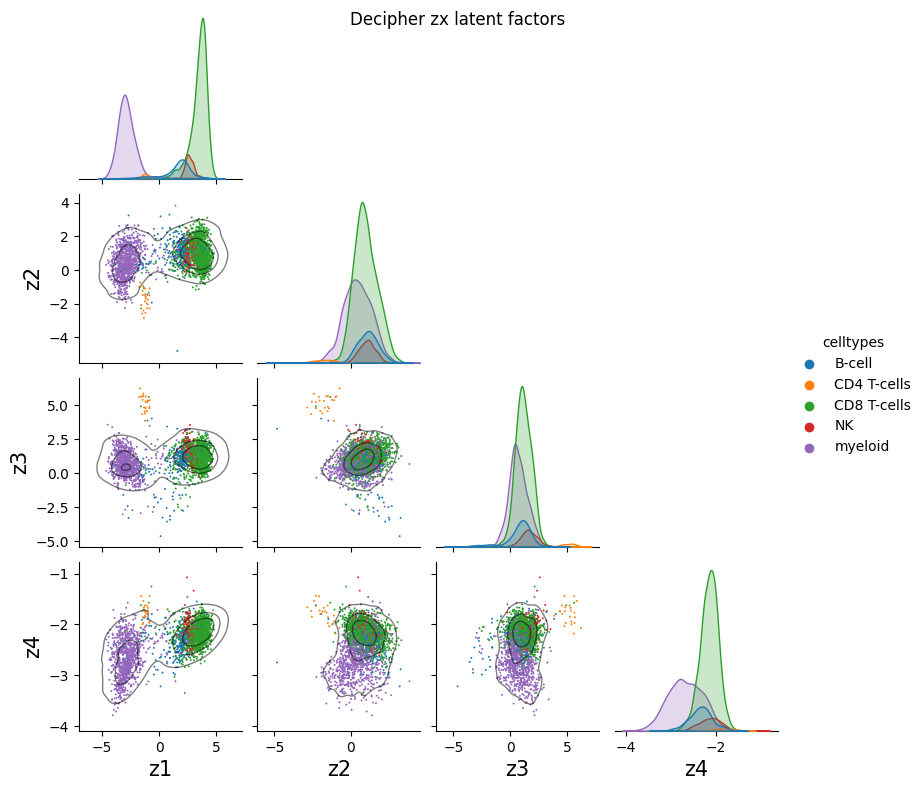

In [53]:
tmp_data = pd.DataFrame(annotated_rna.obsm['decipher_zx'], columns=["z%d" % (i+1) for i in range(10)])
#tmp_data["origin"] = new_atac.obs["origin"].values
tmp_data["celltypes"] = annotated_rna.obs["celltypes"].values

with plt.rc_context({'axes.titlesize':15 , 'axes.labelsize':15}):

    pg = sns.pairplot(
        tmp_data,
        x_vars=["z1", "z2", "z3", "z4"],
        y_vars=["z1", "z2", "z3", "z4"],
        corner=True,
        hue="celltypes",
        plot_kws={"s": 2, "linewidth":0, "rasterized":True},
        height=2)
    pg.map_lower(f, levels=4, color="0", alpha=0.5, linewidths=1,)
plt.suptitle('Decipher zx latent factors')
plt.show()

In [54]:
annotated_rna

AnnData object with n_obs × n_vars = 2626 × 36601
    obs: 'decipher_split', 'blank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'n_counts', 'pheno_louvain', 'celltypes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltypes_colors', 'neighbors', 'pheno_jaccard_q', 'pheno_louvain_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'decipher_vx', 'decipher_zx', 'vx_var'

In [55]:
new_atac.obs['celltypes']=annotated_rna.obs['celltypes']

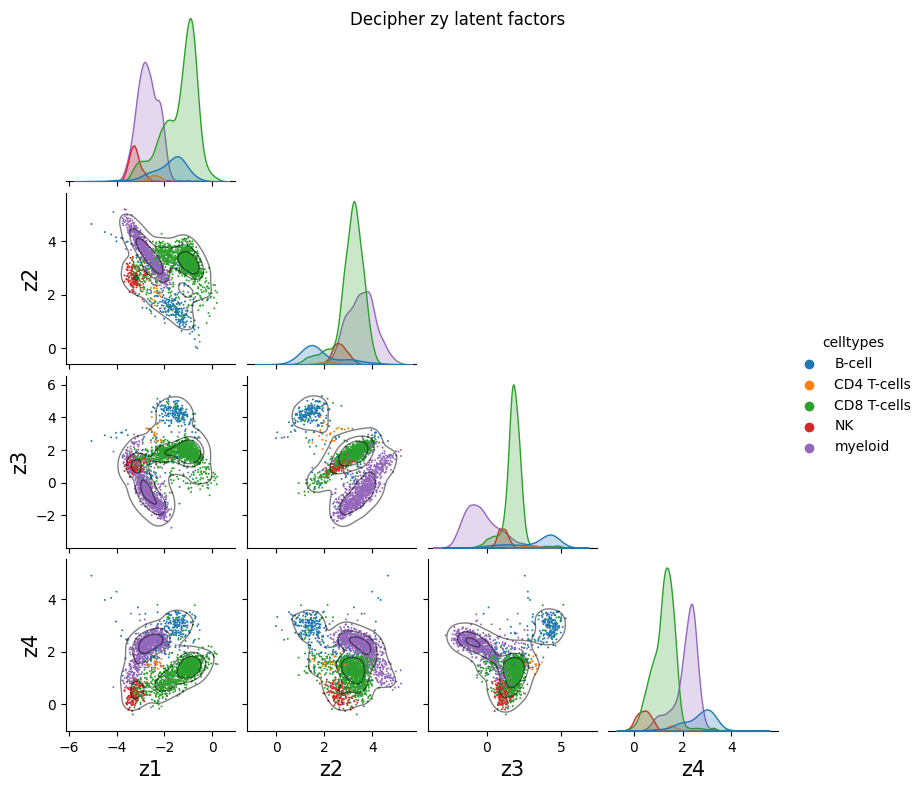

In [56]:
tmp_data = pd.DataFrame(new_atac.obsm['decipher_zy'], columns=["z%d" % (i+1) for i in range(10)])
#tmp_data["origin"] = new_atac.obs["origin"].values
tmp_data["celltypes"] = new_atac.obs["celltypes"].values

with plt.rc_context({'axes.titlesize':15 , 'axes.labelsize':15}):

    pg = sns.pairplot(
        tmp_data,
        x_vars=["z1", "z2", "z3", "z4"],
        y_vars=["z1", "z2", "z3", "z4"],
        corner=True,
        hue="celltypes",
        plot_kws={"s": 2, "linewidth":0, "rasterized":True},
        height=2,
    )
    pg.map_lower(f, levels=4, color="0", alpha=0.5, linewidths=1,)
plt.suptitle('Decipher zy latent factors')
plt.show()


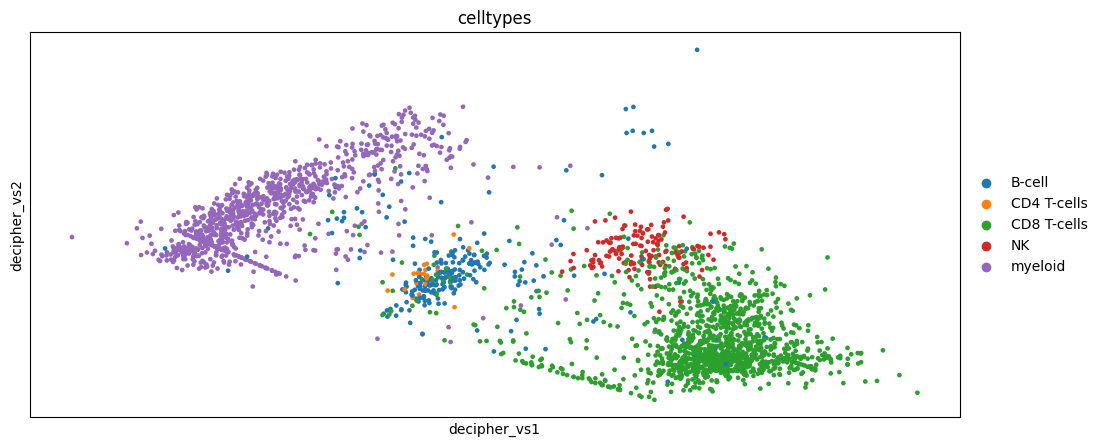

In [57]:
with plt.rc_context({"figure.figsize": (12,5)}):
    fig = sc.pl.embedding(
        sc.pp.subsample(new_atac, 1.0, copy=True),
        basis='decipher_vs',
        color= 'celltypes',
        #palette= 'viridis',
        return_fig=True,
    )
ax = fig.axes[0]
plt.show()

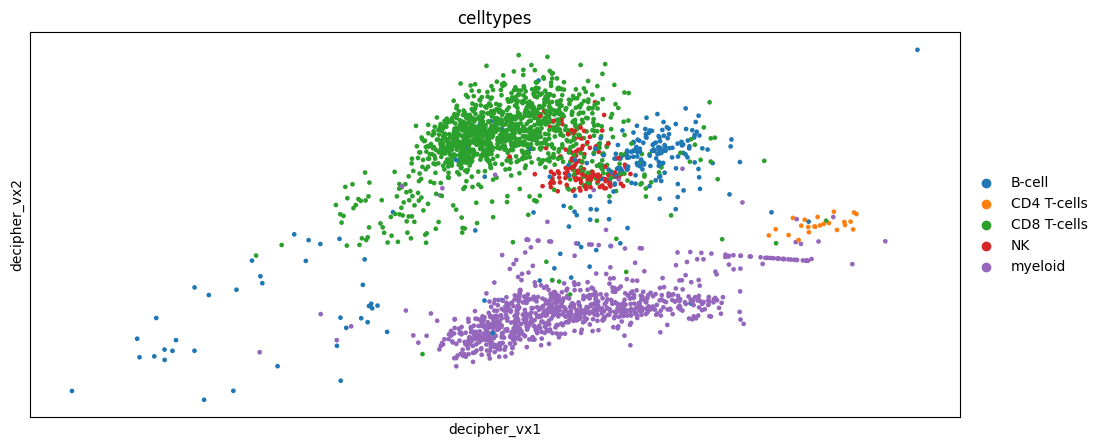

In [58]:
with plt.rc_context({"figure.figsize": (12,5)}):
    fig = sc.pl.embedding(
        sc.pp.subsample(annotated_rna, 1.0, copy=True),
        basis='decipher_vx',
        color= 'celltypes',
        #palette= 'viridis',
        return_fig=True,
    )
ax = fig.axes[0]
plt.show()

In [79]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:


AttributeError: 'tuple' object has no attribute 'state_dict'

In [84]:
config.initialize_from_adata(new_rna, new_atac)

In [95]:
ls

README.md                figs/                    pbmc_rna_decipher.h5ad
architecture_test.ipynb  model                    requirements.txt
decipher/                pbmc_atac_decipher.h5ad


In [94]:
torch.save(decipher, 'model')

In [97]:
torch.save(decipher.state_dict(), 'model_state_dict.pt')
decipher.eval()

Decipher_with_ATAC(
  (decoder_vx_to_zx): ConditionalDenseNN(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=20, bias=True)
    )
    (f): ReLU()
    (batch_norms): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder_vy_to_zy): ConditionalDenseNN(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=20, bias=True)
    )
    (f): ReLU()
    (batch_norms): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder_vs_to_zs): ConditionalDenseNN(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=20, bias=True)
    )
    (f): ReLU()
    (batch_norms): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum

In [85]:
decipher = Decipher_with_ATAC(
        config=config)

V5


In [86]:
decipher.state_dict()

OrderedDict([('decoder_vx_to_zx.layers.0.weight',
              tensor([[-0.6607,  0.6744],
                      [ 0.5639,  0.3558],
                      [-0.6601, -0.0376],
                      [-0.6735,  0.4592],
                      [ 0.6544,  0.4479],
                      [-0.5828, -0.1199],
                      [-0.2823,  0.3855],
                      [ 0.5465,  0.0642],
                      [-0.6642, -0.6816],
                      [-0.6505, -0.4717],
                      [ 0.5946, -0.2228],
                      [ 0.5422, -0.4868],
                      [ 0.5271,  0.6594],
                      [-0.6485,  0.5189],
                      [-0.3442, -0.1595],
                      [-0.3111,  0.6792],
                      [ 0.3009,  0.1704],
                      [ 0.0214, -0.0643],
                      [-0.2921, -0.4932],
                      [ 0.0226,  0.5075],
                      [ 0.0492,  0.3400],
                      [ 0.5256,  0.3879],
                      [-0.

In [98]:
pdac_atac

NameError: name 'pdac_atac' is not defined